# Preparation

In [1]:
# import module
import stlearn as st
from pathlib import Path
st.settings.set_figure_params(dpi=180)

/home/myi/data/conda/envs/stlearn/lib/python3.8/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
# specify PATH to data
BASE_PATH = Path("/shares/rheumatologie.usz/caroline/spatial/SHK166_RA_Knee")

# spot tile is the intermediate result of image pre-processing
TILE_PATH = Path("/data/myi/mt-spatial-transcriptomics/tmp/tiles")
TILE_PATH.mkdir(parents=True, exist_ok=True)

# output path
OUT_PATH = Path("/data/myi/mt-spatial-transcriptomics/results/stLearn/")
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [3]:
# load data
data = st.Read10X(BASE_PATH)
data.var_names_make_unique()

/home/myi/data/conda/envs/stlearn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/myi/data/conda/envs/stlearn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
# pre-processing for gene count table
st.pp.filter_genes(data,min_cells=1)
st.pp.normalize_total(data)
st.pp.log1p(data)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X


In [5]:
# pre-processing for spot image
st.pp.tiling(data, TILE_PATH)

# this step uses deep learning model to extract high-level features from tile images
# may need few minutes to be completed
st.pp.extract_feature(data)

Tiling image: 100%|██████████ [ time left: 00:00 ]
2024-06-18 09:25:26.360506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 09:25:27.395018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs:/.singularity.d/libs
2024-06-18 09:25:27.395082: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-18 09:25:31.418970: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libra

The morphology feature is added to adata.obsm['X_morphology']!


#  run stSME clustering

In [6]:
n_clusters = 4

In [7]:
# run PCA for gene expression data
st.em.run_pca(data,n_comps=50)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [8]:
data_SME = data.copy()
# apply stSME to normalise log transformed data
st.spatial.SME.SME_normalize(data_SME, use_data="raw")
data_SME.X = data_SME.obsm['raw_SME_normalized']
st.pp.scale(data_SME)
st.em.run_pca(data_SME,n_comps=50)

Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by SME is added to adata.obsm['raw_SME_normalized']
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Applying Kmeans cluster ...


/home/myi/data/conda/envs/stlearn/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Kmeans cluster is done! The labels are stored in adata.obs["kmeans"]


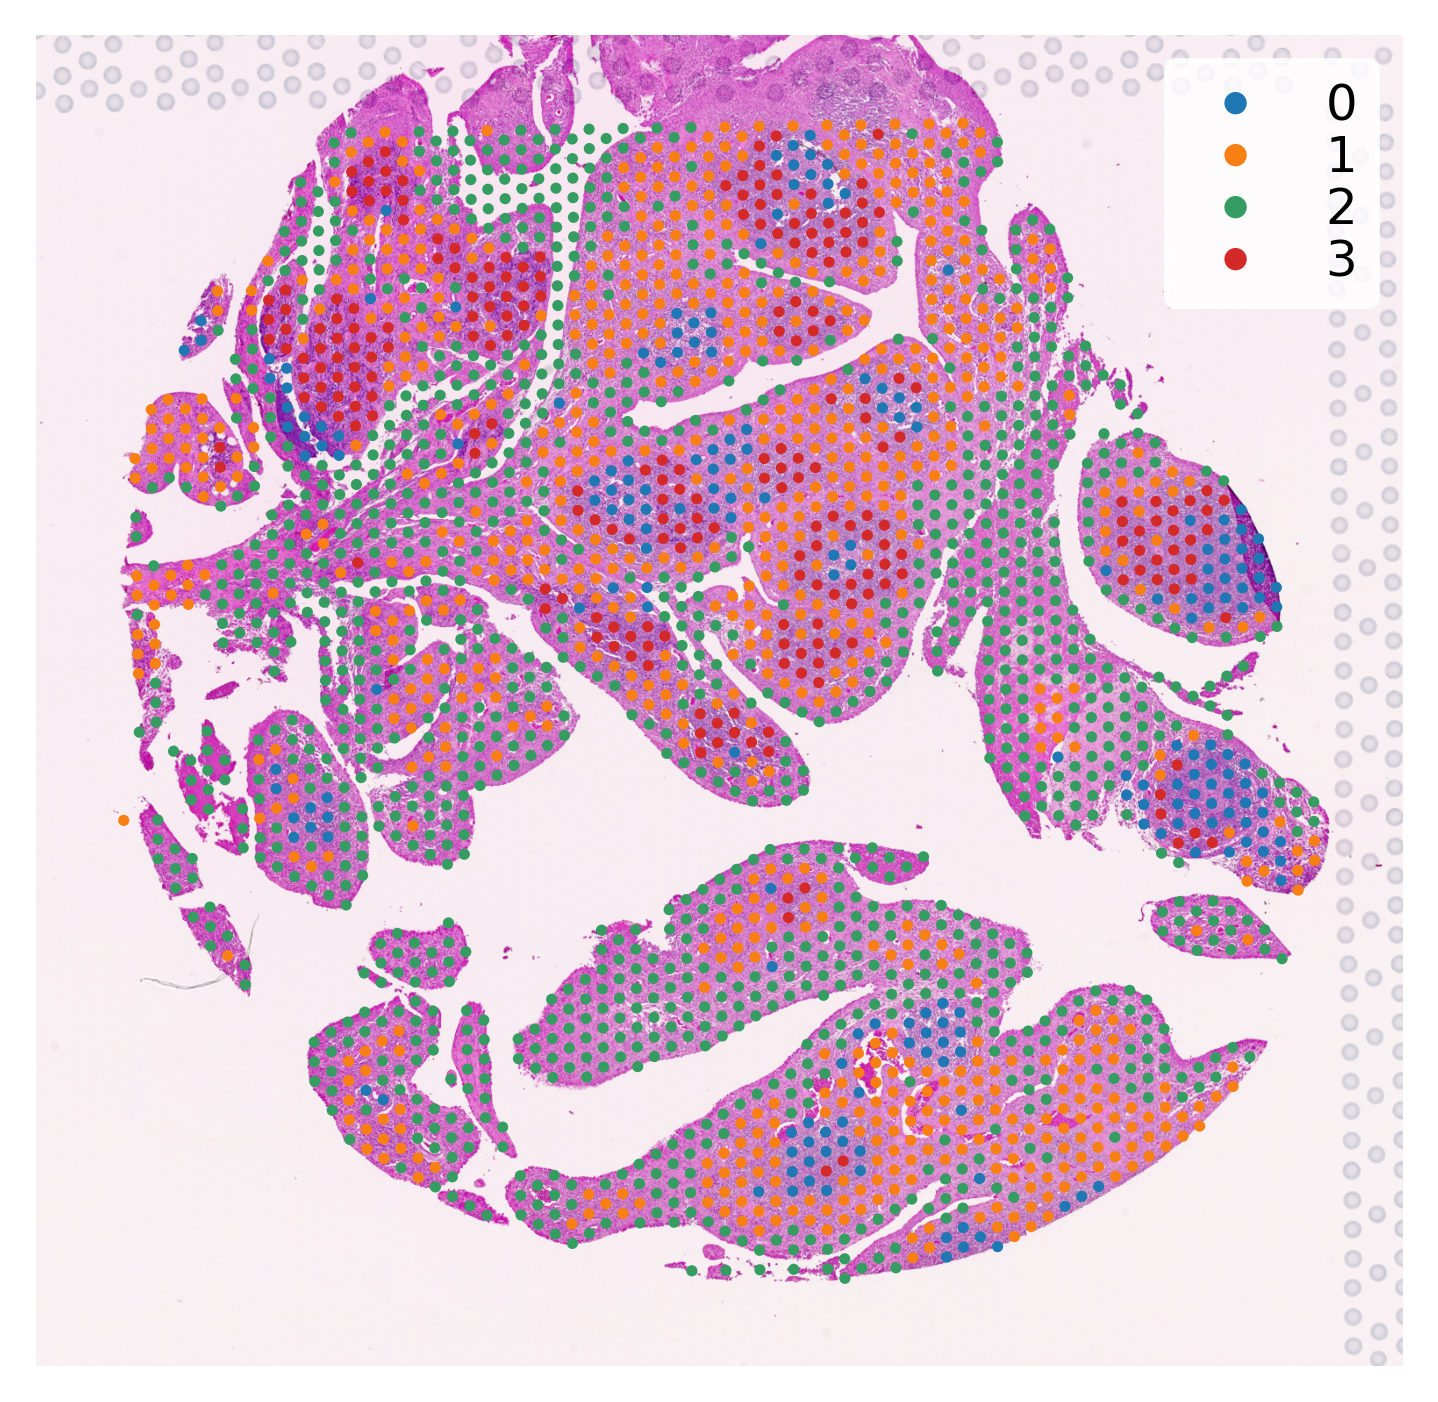

In [9]:
# K-means clustering on stSME normalised PCA
st.tl.clustering.kmeans(data_SME,n_clusters=n_clusters, use_data="X_pca", key_added="X_pca_kmeans")
st.pl.cluster_plot(data_SME, use_label="X_pca_kmeans")

/home/myi/data/conda/envs/stlearn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


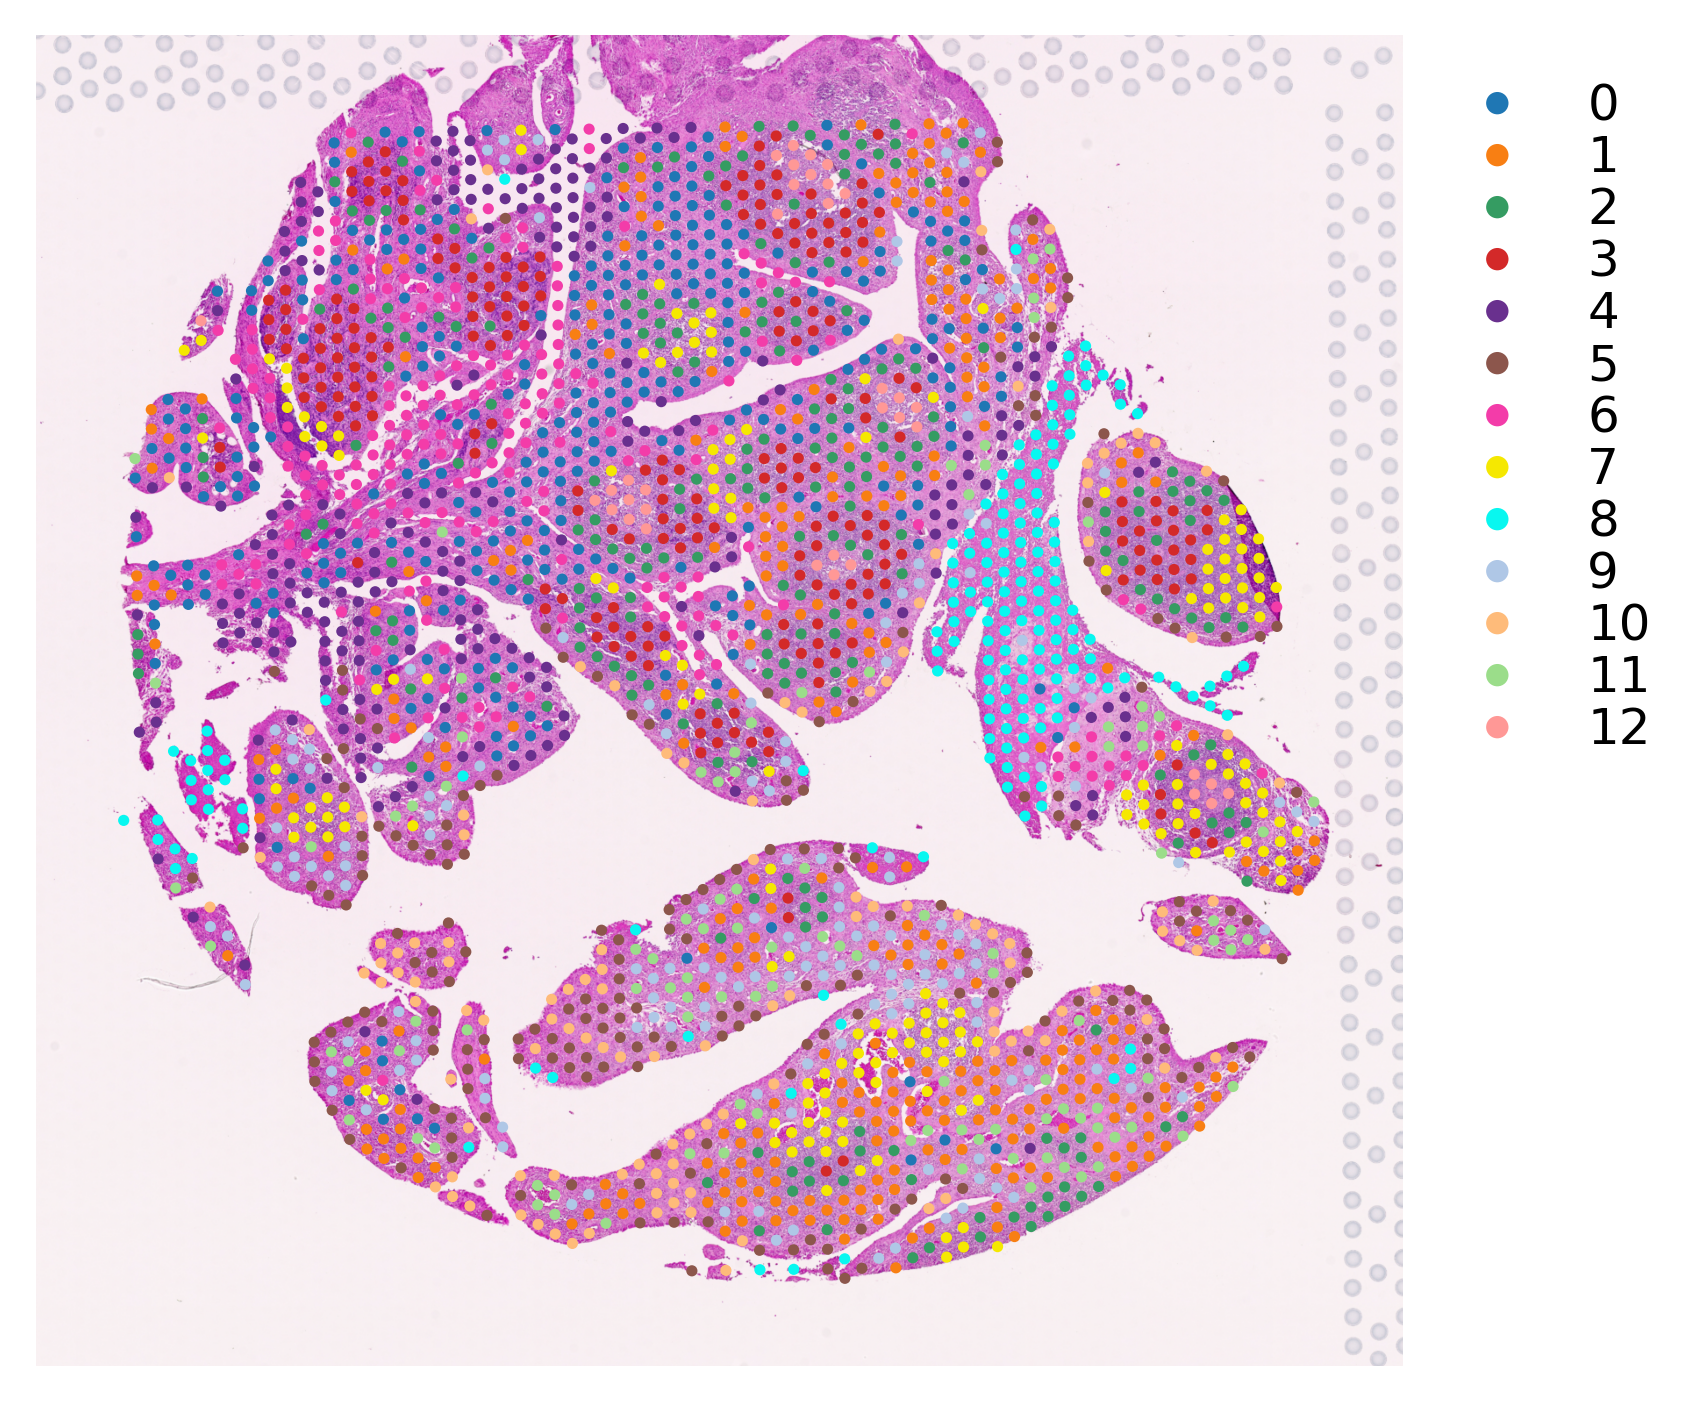

In [10]:
# louvain clustering on stSME normalised data
st.pp.neighbors(data_SME,n_neighbors=10,use_rep='X_pca')
st.tl.clustering.louvain(data_SME, resolution=1.19)
st.pl.cluster_plot(data_SME,use_label="louvain")

In [11]:
data_SME.obs['louvain'].to_csv(Path(OUT_PATH,'louvain_cluster.tsv'), sep='\t', header=False, index=True)